# 1.Подготовка данных

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import matplotlib.pyplot as plt                      
import seaborn as sns         
import pandas as pd  
import numpy as np                                

### Датасет с примером решения:



In [3]:
sample_data= pd.read_csv("/content/drive/MyDrive/competition/sample_submission.csv")
sample_data.head()

,id,target
0,0;133,0
1,0;5,1
2,0;10,0
3,0;396,1
4,0;14,0


In [4]:
sample_data[['user_id', 'cart']] = sample_data['id'].str.split(';', expand = True)
sample_data['user_id'] = sample_data['user_id'].astype('int64')
sample_data.head()

,id,target,user_id,cart
0,0;133,0,0,133
1,0;5,1,0,5
2,0;10,0,0,10
3,0;396,1,0,396
4,0;14,0,0,14


### Данные о покупках пользователей:

In [5]:
users_data = pd.read_csv('/content/drive/MyDrive/competition/train.csv')
users_data['target'] = 0
users_data['count'] = 1
users_data = users_data.drop(['order_completed_at'], axis = 1)
users_data.head()

,user_id,cart,target,count
0,2,399,0,1
1,2,14,0,1
2,2,198,0,1
3,2,88,0,1
4,2,157,0,1


###Если юзер купил товар меньше 2 раз, то target = 0:

In [6]:
users_data['target'] = users_data.duplicated(keep=False).apply(lambda x: 1 if x == True else 0)
users_data.head()

,user_id,cart,target,count
0,2,399,0,1
1,2,14,0,1
2,2,198,1,1
3,2,88,1,1
4,2,157,1,1


### Оставим только данные с user_id из sample_data:

In [7]:
train = users_data[users_data['user_id'].isin(sample_data.user_id)]
train.head()

,user_id,cart,target,count
16,3,399,1,1
17,3,399,1,1
18,4,54,1,1
19,4,55,0,1
20,5,409,1,1


### Разделим train на train_split и test_split

In [8]:
train_split = train.iloc[: (len(train) - len(train)// 5), :]
test_split = train.iloc[(len(train) - len(train)// 5):, :]

###Списки с уникальными категориями:

In [9]:
users_categories = train.groupby(['user_id']).cart.unique()
test_categories = test_split.groupby(['user_id']).cart.unique()

# 2. EDA

### Популярность: сколько раз был заказан каждый товар?

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


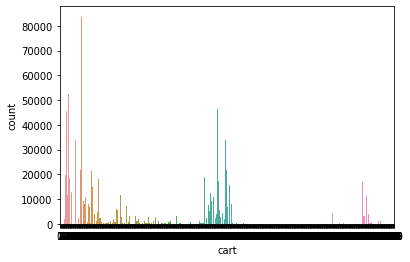

In [10]:
sns.countplot(train['cart'])

In [11]:
top_100 = train.groupby(['cart']).agg({'count' : 'count'}).sort_values\
                                 (by = 'count' , ascending = False).head(100)
top_100.head()

,count
cart,
57,83722
14,72214
61,70478
398,63190
23,55231


In [12]:
def optimization(df, column_with_quotation): #поправка на популярность
  for i in df.index:
    if df.cart[i] in top_100.index:
      df.loc[(df.index == i), column_with_quotation] = 1
  return df

### Как часто категория была куплена отдельными пользователями?

In [13]:
frequency = train_split.groupby(['user_id','cart']).agg({'count' : 'count'})\
                               .sort_values(by = 'count', ascending = False)
frequency.head()

count
user_id cart       
91      14      125
        16      124
        171     121
        55      117
        409     115

## Рекомендательная система (если вы выбрали этот товар, то вам могут понравиться и следующие: [...])

In [14]:
user_matrix = train_split.pivot_table(index='user_id', columns='cart', \
                                      values='target')
user_matrix = user_matrix.fillna(0)
user_matrix.head(3)


cart,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,39,40,...,823,824,825,826,827,828,829,830,831,833,834,835,836,837,838,839,840,842,843,844,845,846,847,848,849,850,851,853,854,857,858,859,863,865,866,867,868,869,873,880
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
def corr_recommendation(category):
  sells = user_matrix[category]
  items_like_this = user_matrix.corrwith(sells)
  recomm = items_like_this.sort_values(ascending=False).head(3)
  list = []
  [list.append(i) for i in recomm.index]
  print(list)

In [16]:
corr_recommendation(6)

[6, 390, 392]


# 3.Выбор ML-модели и обучение

## 3.1 LocalOutlierFactor

In [17]:
X = train_split[['user_id', 'cart']].values
X_test = test_split[['user_id', 'cart']].values
X_final = sample_data[['user_id', 'cart']].values
y = test_split.target

In [18]:
from sklearn.neighbors import LocalOutlierFactor
clf_2 = LocalOutlierFactor(n_neighbors=2, novelty=True)
clf_2.fit(X)
local_output = clf_2.predict(X_test)
local_output = np.clip(local_output, 0, 1)

In [19]:
local_output_final = clf_2.predict(X_final)
local_output_final = np.clip(local_output_final, 0, 1)

## 3.2 IsolationForest

In [20]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(random_state=0).fit(X)
forest_output = clf.predict(X_test)
forest_output = np.clip(forest_output, 0, 1)

In [21]:
forest_output_final = clf.predict(X_final)
forest_output_final = np.clip(forest_output_final, 0, 1)

#3.3 catboost classifier

In [22]:
pip install catboost

In [23]:
from catboost import CatBoostClassifier

train_data = train_split[['user_id', 'cart']] 
train_labels = train_split.target 
test_data  = test_split[['user_id', 'cart']]

model = CatBoostClassifier(iterations=5) 
model.fit(train_data, train_labels) 
prediction_test = model.predict(test_data) 
print(prediction_test) 

Learning rate set to 0.5
0:	learn: 0.4860829	total: 295ms	remaining: 1.18s
1:	learn: 0.4165987	total: 625ms	remaining: 938ms
2:	learn: 0.3880397	total: 1.02s	remaining: 681ms
3:	learn: 0.3752563	total: 1.33s	remaining: 332ms
4:	learn: 0.3683733	total: 1.55s	remaining: 0us
[1 1 1 ... 1 1 1]


In [24]:
catboost_output_final = model.predict(sample_data[['user_id', 'cart']])

###Подготовлю DataFrame с результатом работы моделей:

In [25]:
sample_data.loc[:, ('user_id', 'cart')] = sample_data[['user_id', 'cart']] \
                                                     .astype('str')
my_submit = pd.DataFrame({'id' : sample_data.user_id, 'cart' : sample_data.cart})
my_submit['id_and_cart'] = my_submit['id'].str.cat(my_submit['cart'], sep =";")

In [26]:
my_submit['Local_score'] = local_output_final.tolist()
my_submit['Forest_score'] = forest_output_final.tolist()
my_submit['catboost_score'] = catboost_output_final.tolist()
my_submit.head()

,id,cart,id_and_cart,Local_score,Forest_score,catboost_score
0,0,133,0;133,0,0,1
1,0,5,0;5,1,0,1
2,0,10,0;10,0,0,1
3,0,396,0;396,0,0,1
4,0,14,0;14,0,0,1


###Оценка работы моделей

In [27]:
pre_train = pd.DataFrame({'user_id' : test_split.user_id,\
                             'cart' : test_split.cart,   \
                           'target' : test_split.target})

pre_train['Local_score'] = local_output.tolist()
pre_train['Forest_score'] = forest_output.tolist()
pre_train['catboost_score'] = prediction_test.tolist()

In [28]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y, pre_train.Local_score))
print(roc_auc_score(y, pre_train.Forest_score))
print(roc_auc_score(y, pre_train.catboost_score))

0.6874434190072464
0.6232404307322352
0.5613147942101745


###Поправка на популярность товара

In [29]:
optimization(my_submit, 'Local_score').head()

,id,cart,id_and_cart,Local_score,Forest_score,catboost_score
0,0,133,0;133,0,0,1
1,0,5,0;5,1,0,1
2,0,10,0;10,0,0,1
3,0,396,0;396,0,0,1
4,0,14,0;14,0,0,1


In [30]:
optimization(my_submit, 'catboost_score').head()

,id,cart,id_and_cart,Local_score,Forest_score,catboost_score
0,0,133,0;133,0,0,1
1,0,5,0;5,1,0,1
2,0,10,0;10,0,0,1
3,0,396,0;396,0,0,1
4,0,14,0;14,0,0,1


#4.Из DataFrame в csv

In [31]:
from google.colab import files

In [32]:
submission_with_Local = pd.DataFrame({'id': my_submit.id_and_cart, 'target': my_submit['Local_score']})
submission_with_Local.to_csv('submission_with_Local.csv', index=False)
files.download('submission_with_Local.csv')